In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

import os

In [2]:
df = pd.read_csv("merged_dataset.csv")

pd.set_option('future.no_silent_downcasting', True)
for col in [f"Bubble_BP{i}" for i in range(1, 8)] + ["Bubble_BV1"]:
    df[col] = df[col].replace({"No": 0, "Yes": 1}).astype(int)

print("shape:", df.shape)
df.head()

shape: (212577, 23)


,TIME,P1,P2,P3,P4,P5,P6,P7,Case#,Spacecraft#,...,Opening_Ratio_SV3,Opening_Ratio_SV4,Bubble_BP1,Bubble_BP2,Bubble_BP3,Bubble_BP4,Bubble_BP5,Bubble_BP6,Bubble_BP7,Bubble_BV1
0,0.000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,1,...,100,100,0,0,0,0,0,0,0,0
1,0.001,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,1,...,100,100,0,0,0,0,0,0,0,0
2,0.002,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,1,...,100,100,0,0,0,0,0,0,0,0
3,0.003,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,1,...,100,100,0,0,0,0,0,0,0,0
4,0.004,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,1,...,100,100,0,0,0,0,0,0,0,0


In [3]:
def build_case_tensor(df, case_id):
    sample = df[df["Case#"] == case_id]
    p_cols = [f"P{i}" for i in range(1, 8)]
    tensor = sample[p_cols].values
    spacecraft_id = sample["Spacecraft#"].iloc[0] - 1
    return torch.tensor(tensor, dtype=torch.float32), spacecraft_id

## Task review
### **Task 1 – Normal / Abnormal classification**
- **Objective**: Determine whether the system state is normal.
- **Labels**:
  - `0`: Normal
  - `1`: Abnormal
- **Output**: `2` classes

### **Task 2 – Abnormality Type classification**
- **Objective**: Identify the type of abnormality if present.
- **Labels**:
  - `0`: Placeholder (normal)
  - `1`: Unknown anomaly
  - `2`: Bubble contamination
  - `3`: Valve fault
- **Output**: `4` classes

### **Task 3 – Bubble source identification**
- **Objective**: Locate the exact source of the bubble issue.
- **Labels**:
  - `1–7`: Bubble_BP1 to Bubble_BP7
  - `8`: Bubble_BV1
  - `0`: Placeholder
- **Output**: `9` classes

### **Task 4 – Faulty SV identification**
- **Objective**: Identify the specific SV valve that is faulty.
- **Labels**:
  - `1–4`: SV1 to SV4
  - `0`: Placeholder
- **Output**: `5` classes

### **Task 5 – Faulty SV opening ratio prediction**
- **Objective**: Predict the opening ratio (0–100%) of a faulty SV valve.
- **Labels**:
  - Real-valued float from `0.0` to `100.0`
- **Type**: Regression  
- **Output**: `1` value

In [4]:
# Extract labels from the training set for validation
def extract_labels(df):
    case_ids = df["Case#"].unique()
    label_dict = {}
    for cid in case_ids:
        d = df[df["Case#"] == cid].iloc[0]
        task1 = 0 if d["Condition"].lower() == "normal" else 1 # Set task1 = 0 when condition='normal'

        if task1 == 0:
            task2, task3, task4, task5 = 0, 0, 0, 100.0 # If it's normal, no other problem will exist, so set task2-5 to placeholder value
        else:
            # If it's not normal, first identify if there's any abnormality.
            # Check bubble_bp and bubble_bv if there's any non-zero value
            # If so, set the value of task2 to 2
            # and task3 to the index of where the bubble abnormality occurs
            if d[[f"Bubble_BP{i}" for i in range(1, 8)] + ["Bubble_BV1"]].sum() > 0:
                task2 = 2
                task3 = np.argmax(d[[f"Bubble_BP{i}" for i in range(1, 8)] + ["Bubble_BV1"]].values) + 1
                task4 = 0
                task5 = 100.0
            # If any one of the SV is opening, which means less than 100,
            # set task2 to 3
            # set task4 to the index of where faulty SV valve occurs
            # set task4 to the opening ratio of the SV
            elif d[[f"Opening_Ratio_SV{i}" for i in range(1, 5)]].min() < 100:
                task2 = 3
                sv_values = [d[f"Opening_Ratio_SV{i}"] for i in range(1, 5)]
                task4 = np.argmin(sv_values) + 1
                task5 = float(min(sv_values))
            # Unknown anomaly
            else:
                task2, task3, task4, task5 = 1, 0, 0, 100.0

        label_dict[cid] = {
            "task1": task1,
            "task2": task2,
            "task3": task3,
            "task4": task4,
            "task5": task5
        }
    return label_dict

# Apply this label extracting function to the df
label_dict = extract_labels(df)

**LoadingDataset**

In [5]:
class PHMAPDataset(Dataset):
    def __init__(self, df, label_dict, task="task1", case_ids=None):
        self.df = df
        self.label_dict = label_dict
        self.task = task
        self.case_ids = case_ids if case_ids is not None else list(label_dict.keys())


    def __len__(self):
        return len(self.case_ids)

    def __getitem__(self, idx):
        cid = self.case_ids[idx]
        sample = self.df[self.df["Case#"] == cid]

        p_cols = [f"P{i}" for i in range(1, 8)]
        x = torch.tensor(sample[p_cols].values, dtype=torch.float32)

        spacecraft_id = int(sample["Spacecraft#"].iloc[0]) - 1
        spacecraft_onehot = F.one_hot(torch.tensor(spacecraft_id), num_classes=4).float()

        y = self.label_dict[cid][self.task]
        if self.task == "task5":
            return (x, spacecraft_onehot), torch.tensor([y], dtype=torch.float32)
        return (x, spacecraft_onehot), torch.tensor(y, dtype=torch.long)

### **Model Structure**

- **Input**:
  - `x`: Time-series pressure data `[1200, 7]`. There are 1200 data points for each of the 7 cases.
  - `spacecraft`: One-hot encoded spacecraft ID `[, 4]`. Individual differences in spacecraft should be considered, so encoded ID of spacecrafts are also made as input of the model.
- **Output**:
  - Final classification or regression result (depends on the task)

In [6]:
class CNNLSTM(nn.Module):
    '''
    input_channels: Input features per time step(P1-P7 pressure data);
    cnn_out: number of features that the model will learn from the data
    lstm_hidden: Number of hidden units in each LSTM direction
    num_classes: num_classes varies for different tasks. 2 is a default value for task1

    In short, __init__() defines the model structure, and forward() explains how the model actually processes the input data step by step
    '''

    def __init__(self, input_channels=7, cnn_out=16, lstm_hidden=32, num_classes=2, dropout=0.3):
        super().__init__()
        
        '''
        (B means batchsize)
        * CNN component:
        Input shape:               [B, 7, 1200]      
        → Conv1d → Output:         [B, 32, 1200]
        → BatchNorm1d  → Output:   [B, 32, 1200]    
        → ReLU  → Output:          [B, 32, 1200]
        → MaxPool1d(2)  → Output:  [B, 32, 600]     
        '''
        self.conv1 = nn.Conv1d(input_channels, cnn_out, kernel_size=5, padding=2) # kernel_size: size of sliding window in time steps
        self.bn1 = nn.BatchNorm1d(cnn_out) # Normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.MaxPool1d(2) # Downsampling. Taking the maximum value over every 2 time steps.
        
        '''
        * LSTM component:
        - LSTM requires different input format, so the output of CNN([B, 32, 600]) will be applied permute() and 
            converted to [B, 600, 32]
        - Individual differences in spacecraft should be considered, so encoded ID of spacecrafts are also made as input
        
        LSTM Input shape:          [B, 600, 32]                   |   Spacecraft Input:       [B, 4]
        Output:                    [B, lstm_hidden * 2 = 128]     |   Output                  [B, 16]
        
                                                    Combined: [B, 128 + 16]
        '''
        
        self.lstm = nn.LSTM(cnn_out, lstm_hidden, batch_first=True, bidirectional=True)  # Bi-directional parameter is utilized, 
        # which means lstm will look in both ways at the sequence data, forward and backward.
        self.extra_fc = nn.Linear(4, 16) # full-connection layer for spacecraft ID
        self.final_fc = nn.Linear(lstm_hidden * 2 + 16, num_classes) # Final predicting layer, receiving concatenated input (as explained in the comment above) 

    def forward(self, x, spacecraft):
        x = x.permute(0, 2, 1) # [B, 7, 1200] → [B, 1200, 7]
        x = self.pool(self.dropout(self.relu(self.bn1(self.conv1(x))))) # [B, 600, 32]
        x = x.permute(0, 2, 1) # [B, 32, 600] → [B, 600, 32]
        lstm_out, _ = self.lstm(x) # [B, 600, 128]
        lstm_feat = lstm_out[:, -1, :] # Extract the output at the last time step [B, 128]
        extra_feat = self.extra_fc(spacecraft) # [B, 4] → [B, 16]
        combined = torch.cat([lstm_feat, extra_feat], dim=1) # Concatenate both features → [B, 144] = 128 + 16
        return self.final_fc(combined) # Final classification/regression

## **Model Training**

In [7]:
from sklearn.metrics import classification_report, accuracy_score

def train_model(model, train_loader, optimizer, loss_fn, device, task="task1", num_epochs=256, val_loader=None):
    all_losses = []
    all_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for (x, spacecraft), y in train_loader:
            x, spacecraft, y = x.to(device), spacecraft.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x, spacecraft)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)

            if task != "task5":
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        all_losses.append(avg_loss)

        if task != "task5":
            acc = correct / total
            all_accs.append(acc)
            print(f"[Task: {task}] Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f}")
        else:
            all_accs.append(None)
            print(f"[Task: {task}] Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Acc: -")

        # --- Validation Evaluation per Epoch ---
        if val_loader is not None and task != "task5":
            model.eval()
            val_total_loss = 0
            val_correct = 0
            val_total = 0
            y_true, y_pred = [], []

            with torch.no_grad():
                for (x, spacecraft), y in val_loader:
                    x, spacecraft, y = x.to(device), spacecraft.to(device), y.to(device)
                    outputs = model(x, spacecraft)
                    loss = loss_fn(outputs, y)
                    val_total_loss += loss.item() * x.size(0)

                    preds = outputs.argmax(dim=1)
                    val_correct += (preds == y).sum().item()
                    val_total += y.size(0)
                    y_true.extend(y.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())

            avg_val_loss = val_total_loss / len(val_loader.dataset)
            val_acc = val_correct / val_total
            val_losses.append(avg_val_loss)
            val_accs.append(val_acc)

            print(f"         └─ Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
        else:
            val_losses.append(None)
            val_accs.append(None)

    # Final validation report
    if val_loader is not None and task != "task5":
        print(f"\nValidation Report for {task.upper()} after Epoch {num_epochs}:")
        print(classification_report(y_true, y_pred, zero_division=0))

    return model, all_losses, all_accs, val_losses, val_accs


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Training model for task1
model_task1 = CNNLSTM(num_classes=2).to(device)

# Split case IDs
all_case_ids = list(label_dict.keys())
train_ids, val_ids = train_test_split(
    all_case_ids,
    test_size=0.2,
    stratify=[label_dict[cid]["task1"] for cid in all_case_ids],
    random_state=42
)

# Datasets and loaders
train_ds1 = PHMAPDataset(df, label_dict, task="task1", case_ids=train_ids)
val_ds1 = PHMAPDataset(df, label_dict, task="task1", case_ids=val_ids)

train_loader1 = DataLoader(train_ds1, batch_size=16, shuffle=True)
val_loader1 = DataLoader(val_ds1, batch_size=16, shuffle=False)

# Optimizer
optimizer1 = torch.optim.Adam(model_task1.parameters(), lr=1e-3, weight_decay=1e-4)

# Train
model_task1, loss1, acc1, val_loss1, val_acc1 = train_model(
    model=model_task1,
    train_loader=train_loader1,
    optimizer=optimizer1,
    loss_fn=nn.CrossEntropyLoss(),
    device=device,
    task="task1",
    num_epochs=256,
    val_loader=val_loader1
)


[Task: task1] Epoch 1 | Train Loss: 0.6914 | Train Acc: 0.5248
         └─ Val Loss: 0.6808 | Val Acc: 0.5833
[Task: task1] Epoch 2 | Train Loss: 0.6760 | Train Acc: 0.5957
         └─ Val Loss: 0.6776 | Val Acc: 0.5833
[Task: task1] Epoch 3 | Train Loss: 0.6773 | Train Acc: 0.5957
         └─ Val Loss: 0.6777 | Val Acc: 0.5833
[Task: task1] Epoch 4 | Train Loss: 0.6737 | Train Acc: 0.5957
         └─ Val Loss: 0.6787 | Val Acc: 0.5833
[Task: task1] Epoch 5 | Train Loss: 0.6708 | Train Acc: 0.5957
         └─ Val Loss: 0.6773 | Val Acc: 0.5833
[Task: task1] Epoch 6 | Train Loss: 0.6742 | Train Acc: 0.5957
         └─ Val Loss: 0.6757 | Val Acc: 0.5833
[Task: task1] Epoch 7 | Train Loss: 0.6672 | Train Acc: 0.5957
         └─ Val Loss: 0.6768 | Val Acc: 0.5833
[Task: task1] Epoch 8 | Train Loss: 0.6684 | Train Acc: 0.5957
         └─ Val Loss: 0.6786 | Val Acc: 0.5833
[Task: task1] Epoch 9 | Train Loss: 0.6634 | Train Acc: 0.5957
         └─ Val Loss: 0.6771 | Val Acc: 0.5833
[Task: tas

In [15]:
# Training model for task2
model_task2 = CNNLSTM(num_classes=4).to(device)

train_ids, val_ids = train_test_split(
    all_case_ids,
    test_size=0.2,
    stratify=[label_dict[cid]["task2"] for cid in all_case_ids],
    random_state=42
)

train_ds2 = PHMAPDataset(df, label_dict, task="task2", case_ids=train_ids)
val_ds2 = PHMAPDataset(df, label_dict, task="task2", case_ids=val_ids)

train_loader2 = DataLoader(train_ds2, batch_size=16, shuffle=True)
val_loader2 = DataLoader(val_ds2, batch_size=16, shuffle=False)

optimizer2 = torch.optim.Adam(model_task2.parameters(), lr=1e-3, weight_decay=1e-4)

model_task2, loss2, acc2, val_loss2, val_acc2 = train_model(
    model=model_task2,
    train_loader=train_loader2,
    optimizer=optimizer2,
    loss_fn=nn.CrossEntropyLoss(),
    device=device,
    task="task2",
    num_epochs=256,
    val_loader=val_loader2
)


[Task: task2] Epoch 1 | Train Loss: 1.3810 | Train Acc: 0.2837
         └─ Val Loss: 1.3185 | Val Acc: 0.5833
[Task: task2] Epoch 2 | Train Loss: 1.2497 | Train Acc: 0.5248
         └─ Val Loss: 1.1728 | Val Acc: 0.5833
[Task: task2] Epoch 3 | Train Loss: 1.1191 | Train Acc: 0.5957
         └─ Val Loss: 1.0498 | Val Acc: 0.5833
[Task: task2] Epoch 4 | Train Loss: 1.0287 | Train Acc: 0.5957
         └─ Val Loss: 1.0066 | Val Acc: 0.5833
[Task: task2] Epoch 5 | Train Loss: 0.9887 | Train Acc: 0.5957
         └─ Val Loss: 0.9886 | Val Acc: 0.5833
[Task: task2] Epoch 6 | Train Loss: 0.9683 | Train Acc: 0.5957
         └─ Val Loss: 0.9756 | Val Acc: 0.5833
[Task: task2] Epoch 7 | Train Loss: 0.9561 | Train Acc: 0.5957
         └─ Val Loss: 0.9609 | Val Acc: 0.5833
[Task: task2] Epoch 8 | Train Loss: 0.9545 | Train Acc: 0.5957
         └─ Val Loss: 0.9516 | Val Acc: 0.5833
[Task: task2] Epoch 9 | Train Loss: 0.9378 | Train Acc: 0.5957
         └─ Val Loss: 0.9503 | Val Acc: 0.5833
[Task: tas

In [16]:
# Training model for task3
model_task3 = CNNLSTM(num_classes=9).to(device)

train_ids, val_ids = train_test_split(
    all_case_ids,
    test_size=0.2,
    stratify=[label_dict[cid]["task3"] for cid in all_case_ids],
    random_state=42
)

train_ds3 = PHMAPDataset(df, label_dict, task="task3", case_ids=train_ids)
val_ds3 = PHMAPDataset(df, label_dict, task="task3", case_ids=val_ids)

train_loader3 = DataLoader(train_ds3, batch_size=16, shuffle=True)
val_loader3 = DataLoader(val_ds3, batch_size=16, shuffle=False)

optimizer3 = torch.optim.Adam(model_task3.parameters(), lr=1e-3, weight_decay=1e-4)

model_task3, loss3, acc3, val_loss3, val_acc3 = train_model(
    model=model_task3,
    train_loader=train_loader3,
    optimizer=optimizer3,
    loss_fn=nn.CrossEntropyLoss(),
    device=device,
    task="task3",
    num_epochs=256,
    val_loader=val_loader3
)


[Task: task3] Epoch 1 | Train Loss: 2.1083 | Train Acc: 0.3617
         └─ Val Loss: 1.9844 | Val Acc: 0.8611
[Task: task3] Epoch 2 | Train Loss: 1.8337 | Train Acc: 0.8652
         └─ Val Loss: 1.7047 | Val Acc: 0.8611
[Task: task3] Epoch 3 | Train Loss: 1.4751 | Train Acc: 0.8652
         └─ Val Loss: 1.2830 | Val Acc: 0.8611
[Task: task3] Epoch 4 | Train Loss: 1.0534 | Train Acc: 0.8652
         └─ Val Loss: 0.8165 | Val Acc: 0.8611
[Task: task3] Epoch 5 | Train Loss: 0.7353 | Train Acc: 0.8652
         └─ Val Loss: 0.6867 | Val Acc: 0.8611
[Task: task3] Epoch 6 | Train Loss: 0.6695 | Train Acc: 0.8652
         └─ Val Loss: 0.7168 | Val Acc: 0.8611
[Task: task3] Epoch 7 | Train Loss: 0.6766 | Train Acc: 0.8652
         └─ Val Loss: 0.7328 | Val Acc: 0.8611
[Task: task3] Epoch 8 | Train Loss: 0.6638 | Train Acc: 0.8652
         └─ Val Loss: 0.7230 | Val Acc: 0.8611
[Task: task3] Epoch 9 | Train Loss: 0.6552 | Train Acc: 0.8652
         └─ Val Loss: 0.7106 | Val Acc: 0.8611
[Task: tas

In [17]:
# Training model for task4
model_task4 = CNNLSTM(num_classes=5).to(device)

train_ids, val_ids = train_test_split(
    all_case_ids,
    test_size=0.2,
    stratify=[label_dict[cid]["task4"] for cid in all_case_ids],
    random_state=42
)

train_ds4 = PHMAPDataset(df, label_dict, task="task4", case_ids=train_ids)
val_ds4 = PHMAPDataset(df, label_dict, task="task4", case_ids=val_ids)

train_loader4 = DataLoader(train_ds4, batch_size=16, shuffle=True)
val_loader4 = DataLoader(val_ds4, batch_size=16, shuffle=False)

optimizer4 = torch.optim.Adam(model_task4.parameters(), lr=1e-3, weight_decay=1e-4)

model_task4, loss4, acc4, val_loss4, val_acc4 = train_model(
    model=model_task4,
    train_loader=train_loader4,
    optimizer=optimizer4,
    loss_fn=nn.CrossEntropyLoss(),
    device=device,
    task="task4",
    num_epochs=256,
    val_loader=val_loader4
)


[Task: task4] Epoch 1 | Train Loss: 1.5630 | Train Acc: 0.3191
         └─ Val Loss: 1.5078 | Val Acc: 0.7222
[Task: task4] Epoch 2 | Train Loss: 1.3583 | Train Acc: 0.7234
         └─ Val Loss: 1.3288 | Val Acc: 0.7222
[Task: task4] Epoch 3 | Train Loss: 1.1233 | Train Acc: 0.7305
         └─ Val Loss: 1.1118 | Val Acc: 0.7222
[Task: task4] Epoch 4 | Train Loss: 1.0197 | Train Acc: 0.7305
         └─ Val Loss: 0.9840 | Val Acc: 0.7222
[Task: task4] Epoch 5 | Train Loss: 0.9811 | Train Acc: 0.7305
         └─ Val Loss: 0.9967 | Val Acc: 0.7222
[Task: task4] Epoch 6 | Train Loss: 0.9689 | Train Acc: 0.7305
         └─ Val Loss: 0.9926 | Val Acc: 0.7222
[Task: task4] Epoch 7 | Train Loss: 0.9570 | Train Acc: 0.7305
         └─ Val Loss: 0.9835 | Val Acc: 0.7222
[Task: task4] Epoch 8 | Train Loss: 0.9588 | Train Acc: 0.7305
         └─ Val Loss: 0.9791 | Val Acc: 0.7222
[Task: task4] Epoch 9 | Train Loss: 0.9783 | Train Acc: 0.7305
         └─ Val Loss: 0.9750 | Val Acc: 0.7222
[Task: tas

In [18]:
# Task 5 - Regression
model_task5 = CNNLSTM(num_classes=1).to(device)

train_ids, val_ids = train_test_split(
    all_case_ids,
    test_size=0.2,
    stratify=[label_dict[cid]["task1"] for cid in all_case_ids],
    random_state=42
)

train_ds5 = PHMAPDataset(df, label_dict, task="task5", case_ids=train_ids)
val_ds5 = PHMAPDataset(df, label_dict, task="task5", case_ids=val_ids)

train_loader5 = DataLoader(train_ds5, batch_size=16, shuffle=True)
val_loader5 = DataLoader(val_ds5, batch_size=16, shuffle=False)

optimizer5 = torch.optim.Adam(model_task5.parameters(), lr=1e-3, weight_decay=1e-4)

model_task5, loss5, acc5, val_loss5, val_acc5 = train_model(
    model=model_task5,
    train_loader=train_loader5,
    optimizer=optimizer5,
    loss_fn=nn.MSELoss(),
    device=device,
    task="task5",
    num_epochs=256,
    val_loader=val_loader5
)


[Task: task5] Epoch 1 | Train Loss: 7904.9098 | Train Acc: -
[Task: task5] Epoch 2 | Train Loss: 7844.4726 | Train Acc: -
[Task: task5] Epoch 3 | Train Loss: 7768.5482 | Train Acc: -
[Task: task5] Epoch 4 | Train Loss: 7655.7574 | Train Acc: -
[Task: task5] Epoch 5 | Train Loss: 7494.6244 | Train Acc: -
[Task: task5] Epoch 6 | Train Loss: 7304.6636 | Train Acc: -
[Task: task5] Epoch 7 | Train Loss: 7142.7785 | Train Acc: -
[Task: task5] Epoch 8 | Train Loss: 6986.6015 | Train Acc: -
[Task: task5] Epoch 9 | Train Loss: 6850.3581 | Train Acc: -
[Task: task5] Epoch 10 | Train Loss: 6709.0964 | Train Acc: -
[Task: task5] Epoch 11 | Train Loss: 6567.9245 | Train Acc: -
[Task: task5] Epoch 12 | Train Loss: 6441.0370 | Train Acc: -
[Task: task5] Epoch 13 | Train Loss: 6313.7385 | Train Acc: -
[Task: task5] Epoch 14 | Train Loss: 6198.8059 | Train Acc: -
[Task: task5] Epoch 15 | Train Loss: 6082.7905 | Train Acc: -
[Task: task5] Epoch 16 | Train Loss: 5972.5634 | Train Acc: -
[Task: task5] Epo

**Visualizing training process**

In [19]:
def visualize_classification_training(train_losses, train_accs, val_losses, val_accs, task="task1"):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # --- Loss Curve ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="red")
    if val_losses is not None:
        plt.plot(epochs, val_losses, label="Val Loss", color="orange")
    plt.title(f"[{task.upper()}] Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # --- Accuracy Curve ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Acc", color="blue")
    if val_accs is not None:
        plt.plot(epochs, val_accs, label="Val Acc", color="green")
    plt.title(f"[{task.upper()}] Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"[{task.upper()}] Training and Validation Summary", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print final values
    if val_accs is not None and val_accs[-1] is not None:
        print(f"Final Train Acc: {train_accs[-1]:.4f} | Final Val Acc: {val_accs[-1]:.4f}")
    else:
        print(f"Final Train Acc: {train_accs[-1]:.4f}")


In [20]:
def visualize_task5(model, train_losses, val_losses, val_loader, device, task="task5"):
    model.eval()
    true_vals = []
    pred_vals = []

    with torch.no_grad():
        for (x, spacecraft), y in val_loader:
            x, spacecraft = x.to(device), spacecraft.to(device)
            outputs = model(x, spacecraft)
            pred_vals.extend(outputs.view(-1).cpu().numpy())
            true_vals.extend(y.view(-1).cpu().numpy())

    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    residuals = true_vals - pred_vals
    epochs = list(range(1, len(train_losses) + 1))

    min_epoch = np.argmin(val_losses) + 1 if any(v is not None for v in val_losses) else None
    min_val_loss = min([v for v in val_losses if v is not None]) if min_epoch else None

    # --- Plotting ---
    plt.figure(figsize=(18, 5))

    # 1. Loss Curve
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="red")
    if any(v is not None for v in val_losses):
        plt.plot(epochs, val_losses, label="Val Loss", color="blue")
        plt.scatter(min_epoch, min_val_loss, color='black', zorder=5)
        plt.text(min_epoch, min_val_loss + 0.03 * min(train_losses), f"Min Val Loss: {min_val_loss:.2f} (Ep{min_epoch})", fontsize=9)
    plt.title(f"[{task.upper()}] Train vs Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.legend()

    # 2. Predicted vs True
    plt.subplot(1, 3, 2)
    plt.scatter(true_vals, pred_vals, alpha=0.6, edgecolors='k')
    plt.plot([0, 100], [0, 100], 'r--', label="Ideal")
    plt.title("Predicted vs. True (Validation Set)")
    plt.xlabel("True Value")
    plt.ylabel("Predicted Value")
    plt.grid(True)
    plt.legend()

    # 3. Residual Plot
    plt.subplot(1, 3, 3)
    plt.scatter(true_vals, residuals, alpha=0.6, edgecolors='k')
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Residual Plot (True - Predicted)")
    plt.xlabel("True Value")
    plt.ylabel("Residual")
    plt.grid(True)

    plt.suptitle(f"[{task.upper()}] Regression Training Summary", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Summary ---
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals ** 2))
    print(f"Final Report for {task.upper()}:")
    print(f"- Final Train Loss: {train_losses[-1]:.2f}")
    if min_val_loss:
        print(f"- Best Val Loss: {min_val_loss:.2f} (Epoch {min_epoch})")
    print(f"- MAE on Validation Set: {mae:.2f}")
    print(f"- RMSE on Validation Set: {rmse:.2f}")

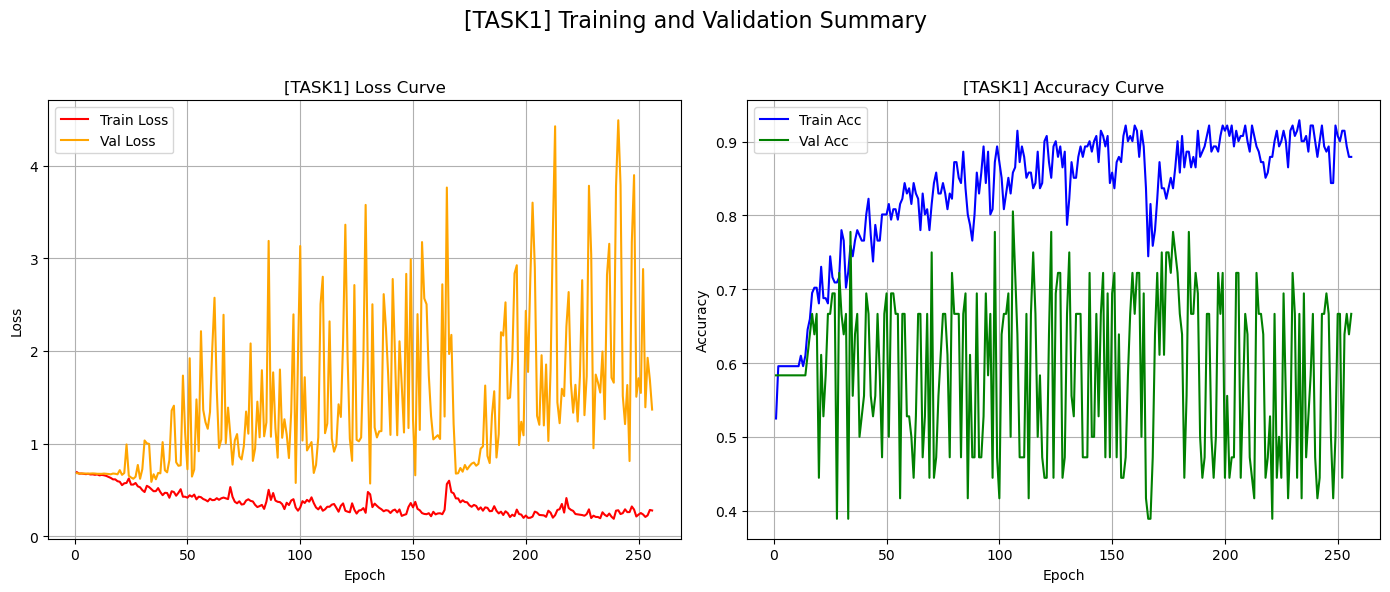

Final Train Acc: 0.8794 | Final Val Acc: 0.6667


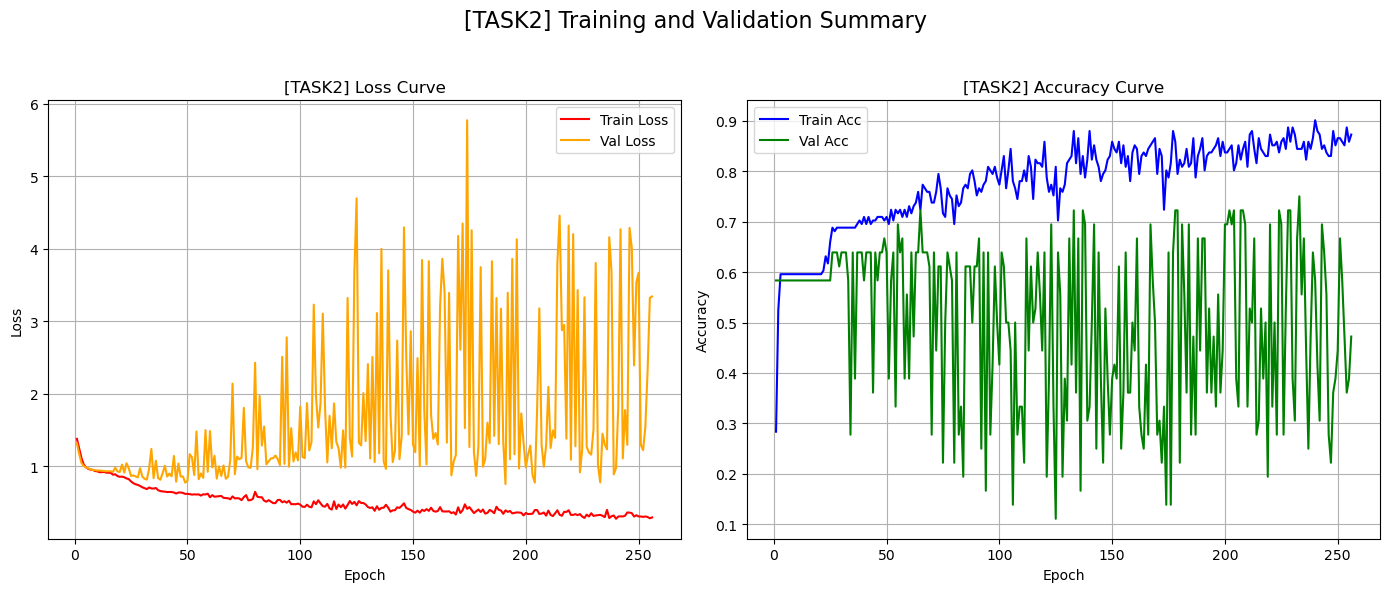

Final Train Acc: 0.8723 | Final Val Acc: 0.4722


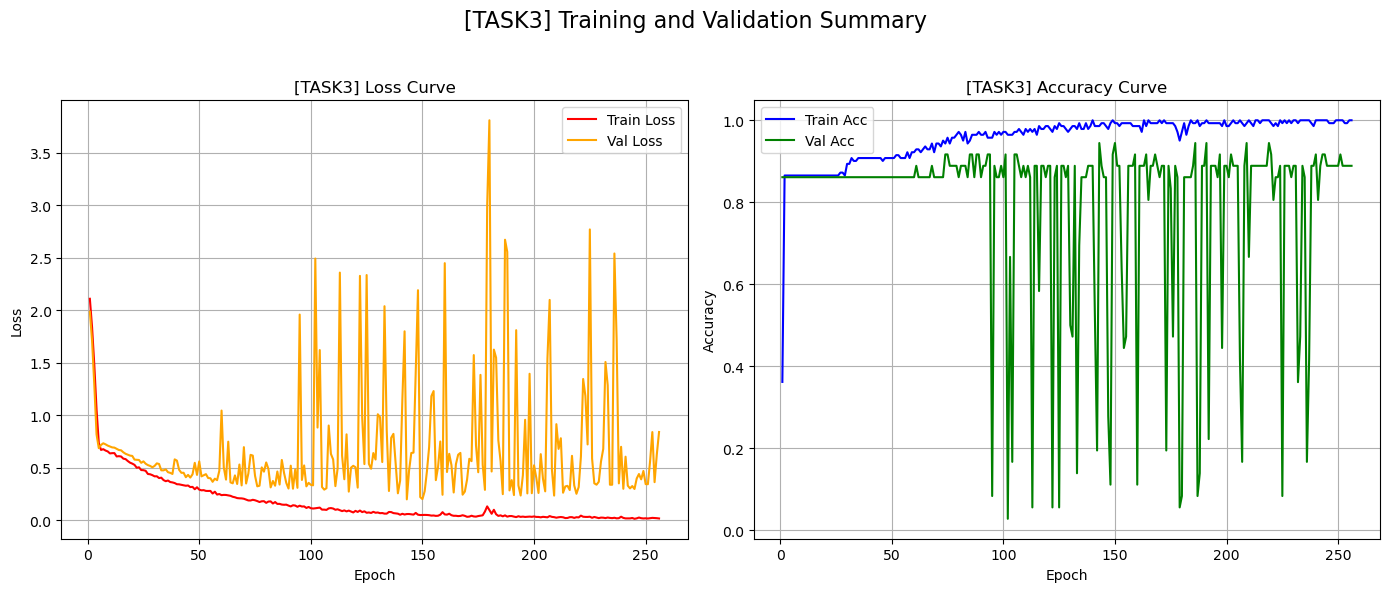

Final Train Acc: 1.0000 | Final Val Acc: 0.8889


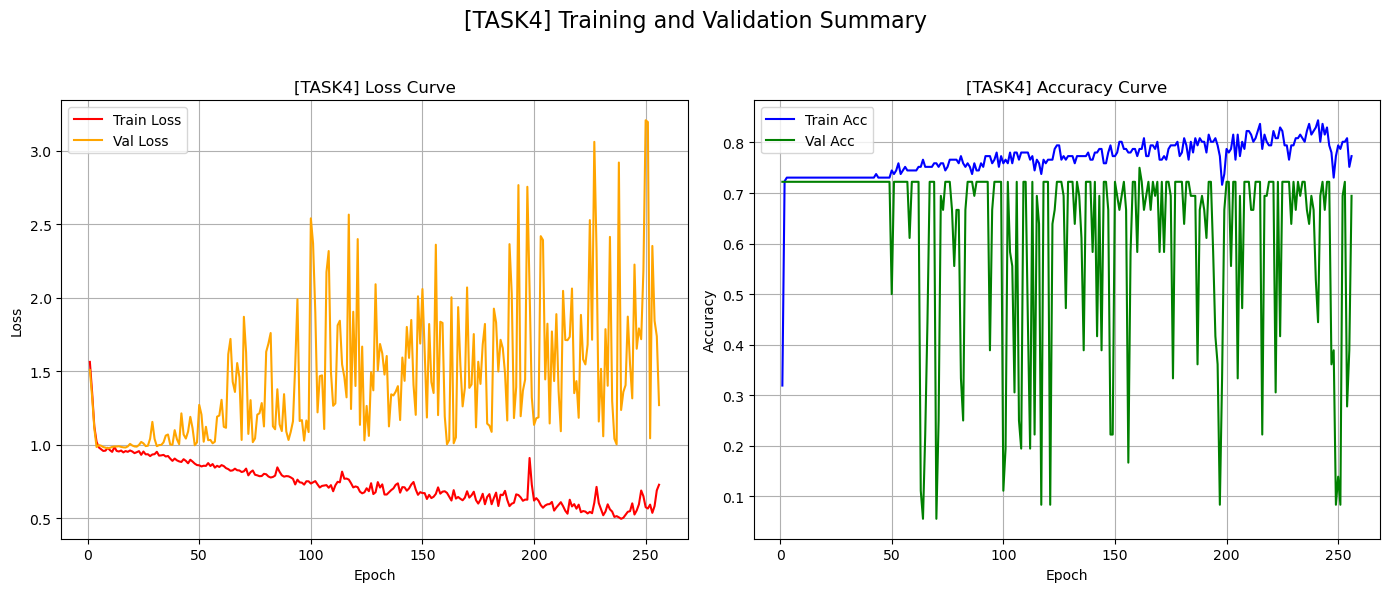

Final Train Acc: 0.7730 | Final Val Acc: 0.6944


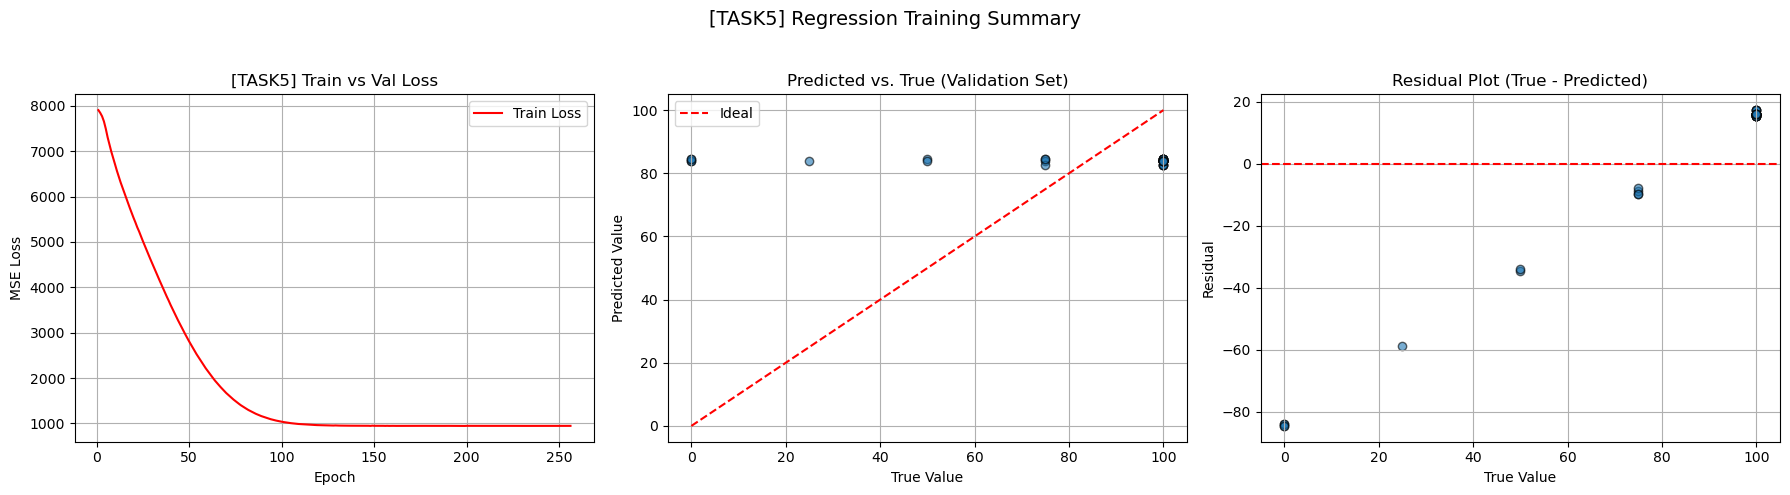

Final Report for TASK5:
- Final Train Loss: 946.37
- MAE on Validation Set: 25.07
- RMSE on Validation Set: 33.74


In [31]:
# Task1
visualize_classification_training(loss1, acc1, val_loss1, val_acc1, task="task1")

# Task2
visualize_classification_training(loss2, acc2, val_loss2, val_acc2, task="task2")

# Task3
visualize_classification_training(loss3, acc3, val_loss3, val_acc3, task="task3")

# Task4
visualize_classification_training(loss4, acc4, val_loss4, val_acc4, task="task4")

# Task5
visualize_task5(model=model_task5,
    train_losses=loss5,
    val_losses=val_loss5,
    val_loader=val_loader5,
    device=device,
    task="task5")

**Save to local**

In [67]:
MODEL_DIR = "./saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

def save_model(model, task):
    torch.save(model.state_dict(), f"{MODEL_DIR}/cnn_lstm_{task}.pt")

def load_model(task, num_classes):
    model = CNNLSTM(num_classes=num_classes)
    model.load_state_dict(torch.load(f"{MODEL_DIR}/cnn_lstm_{task}.pt", map_location=torch.device("cpu")))
    return model

In [79]:
save_model(model_task1, "task1")
save_model(model_task2, "task2")
save_model(model_task3, "task3")
save_model(model_task4, "task4")
save_model(model_task5, "task5")

**Predicting on test set**

In [128]:
# Load model from local
model1 = load_model("task1", num_classes=2)
model2 = load_model("task2", num_classes=4)
model3 = load_model("task3", num_classes=9)
model4 = load_model("task4", num_classes=5)
model5 = load_model("task5", num_classes=1)

/var/folders/dp/lsx_n6js19v5kcttzn83ncph0000gn/T/ipykernel_19573/365520993.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{MODEL_DIR}

In [129]:
# Apply same process as training set
def one_hot_spacecraft(spacecraft_id):
    one_hot = torch.zeros(4)
    one_hot[int(spacecraft_id) - 1] = 1
    return one_hot

def build_test_case_tensor(df, cid):
    d = df[df["Case#"] == cid]
    sequence = d[["P1", "P2", "P3", "P4", "P5", "P6", "P7"]].values.astype(np.float32)
    sequence_tensor = torch.tensor(sequence)  # (1200, 7)
    spacecraft_id = d["Spacecraft#"].iloc[0]
    spacecraft_tensor = one_hot_spacecraft(spacecraft_id)  # (4,)
    return sequence_tensor.unsqueeze(0), spacecraft_tensor.unsqueeze(0)

In [88]:
test_df = pd.read_csv("merged_test_dataset.csv")

- Just to clarify again, the result of the test set is as below:
- `Case#`: The identifier for each test case (e.g., 178, 179, ...)
- `Task1`: **Normal / Abnormal Classification**  
   - `0` = Normal  
   - `1` = Abnormal
- `Task2`: **Abnormality Type Classification**  
   - `0` = Normal (same as `Task1=0`)  
   - `1` = Unknown anomaly  
   - `2` = Bubble contamination  
   - `3` = SV valve fault
- `Task3`: **Bubble Source Identification**  
   - `1–7` = Bubble_BP1 to Bubble_BP7  
   - `8` = Bubble_BV1  
   - `0` = No bubble (used when `Task2 ≠ 2`)
- `Task4`: **Faulty SV Valve Index**  
   - `1–4` = SV1 to SV4  
   - `0` = No fault (used when `Task2 ≠ 3`)
- `Task5`: **SV Opening Ratio Regression**  
   - Float value between `0.0` to `100.0`  
   - Represents predicted opening percentage of the faulty SV valve


In [90]:
test_case_ids = test_df["Case#"].unique()
results = []

for cid in test_case_ids:
    x_seq, x_sc = build_test_case_tensor(test_df, cid)
    x_seq, x_sc = x_seq.to(device), x_sc.to(device)

    with torch.no_grad():
        out1 = model1(x_seq, x_sc).argmax(dim=1).item()
        out2 = model2(x_seq, x_sc).argmax(dim=1).item()
        out3 = model3(x_seq, x_sc).argmax(dim=1).item()
        out4 = model4(x_seq, x_sc).argmax(dim=1).item()
        out5 = model5(x_seq, x_sc).squeeze().item()

    results.append({
        "Case#": cid,
        "Task1": out1,
        "Task2": out2,
        "Task3": out3,
        "Task4": out4,
        "Task5": round(out5, 2)
    })

result_df = pd.DataFrame(results)
result_df.to_csv("test_predictions.csv", index=False)
print(result_df)


    Case#  Task1  Task2  Task3  Task4  Task5
0     178      1      2      2      0  75.10
1     179      0      0      0      0  75.10
2     180      0      0      0      0  75.10
3     181      0      0      0      0  75.10
4     182      0      0      0      0  75.10
5     183      0      0      0      0  75.10
6     184      1      2      4      0  75.10
7     185      0      0      0      0  75.10
8     186      1      2      6      0  75.10
9     187      0      0      0      0  75.10
10    188      0      0      0      0  75.10
11    189      0      0      0      0  75.10
12    190      0      0      0      0  75.10
13    191      0      0      0      0  75.10
14    192      1      2      2      0  75.10
15    193      1      2      8      0  75.10
16    194      0      0      0      0  75.10
17    195      0      0      0      0  75.10
18    196      1      2      4      0  75.10
19    197      1      2      7      0  75.10
20    198      0      0      0      0  75.10
21    199 